In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\shahe\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shahe\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shahe\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shahe\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
TRAIN_DIR = ('C:/Users/shahe/Desktop/chest_xray/train/')
TEST_DIR = ('C:/Users/shahe/Desktop/chest_xray/test/')
VAL_DIR = ('C:/Users/shahe/Desktop/chest_xray/val/')

In [3]:
# re-size all the images to a size VGG-16 expects.
IMAGE_SIZE = [224, 224]

# Set the batch size
BATCH_SIZE = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
NUM_CLASSES = 2 # We are aware of it.

In [4]:
import os
CLASSES = os.listdir(TRAIN_DIR)
NUM_CLASSES = len(CLASSES)
print("Class --> {} \n and the length is : {}".format(CLASSES, NUM_CLASSES))

Class --> ['NORMAL', 'PNEUMONIA'] 
 and the length is : 2


In [5]:
# Image Data Augmentation

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [6]:
# Import the images from the train dataset.
# Make sure to provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 5216 images belonging to 2 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
test_set = test_datagen.flow_from_directory(
    directory = TEST_DIR,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 624 images belonging to 2 classes.


In [9]:
# Import the VGG 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [10]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [11]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(NUM_CLASSES, activation='softmax')(x)

In [12]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=1,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1
163/163 [==============================] - 1736s 11s/step - loss: 0.1929 - acc: 0.9224 - val_loss: 0.2954 - val_acc: 0.8990


In [17]:
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory(
    directory = VAL_DIR,
    target_size = (224, 224),
    batch_size = 1,
    shuffle=False,
    seed=42,
    class_mode = 'binary'
)

Found 16 images belonging to 2 classes.


In [18]:
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_set, steps = validation_steps)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

AttributeError: 'DirectoryIterator' object has no attribute 'ndim'

In [16]:
# get sample image to test.
img_normal = image.load_img('C:/Users/shahe/Desktop/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg', target_size = (224, 224))
img_pneumonia = image.load_img('C:/Users/shahe/Desktop/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg', target_size = (224, 224))

In [17]:
def model_predict(img, actual):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x_processed = preprocess_input(x)
    result = model.predict(x_processed)
    print(result)
    if(result[0][0] < 0.5):
        result="pneumonia"
    else:
        result="normal"
        
    plt.figure()
    plt.imshow(img)
    plt.title('Actual : {} --> Predicted  : {}'.format(actual, result))
    

[[1. 0.]]
[[0. 1.]]


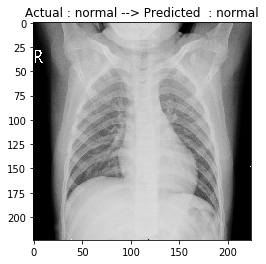

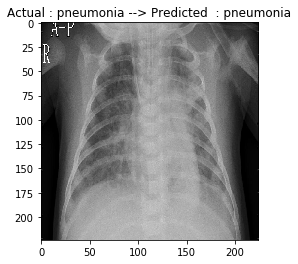

In [18]:
pred_normal = model_predict(img_normal, "normal")
pred_pneumonia = model_predict(img_pneumonia, "pneumonia")

[[0. 1.]]


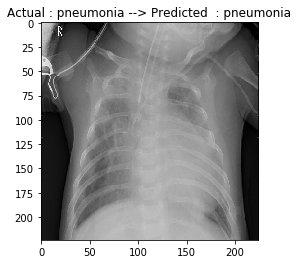

In [19]:
img = image.load_img('C:/Users/shahe/Desktop/chest_xray/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg', target_size = (224, 224))

pred = model_predict(img, "pneumonia")

In [20]:
model.save("pneumonia_model.json")

In [ ]:
"""
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

"""